# Simulate long-range migration edge 

As an initial attempt, I will just add a **single** long range migration edge to a specific internal node **on top** of the original triangular lattice from before. I can envision using a greedy approach to fitting this likelihood function by adding a penalty term for which two nodes gets this edge...

Here, I will test the output of the function as I am developing it (code adapted from `sandbox.ipynb`)

## Changes to original code base:
1. adding function `setup_graph_long_range` in `sim.py`

## Imports

In [3]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from pandas_plink import read_plink
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.cross_validation import comp_mats

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing function + visualization
*Note: nodes are numbered left-right, bottom-top by default in `networkx`*

In [197]:
## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=[(0,12)], long_range_edges=[2.0])

In [198]:
gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 100
Simulating ~SNP 250
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 950


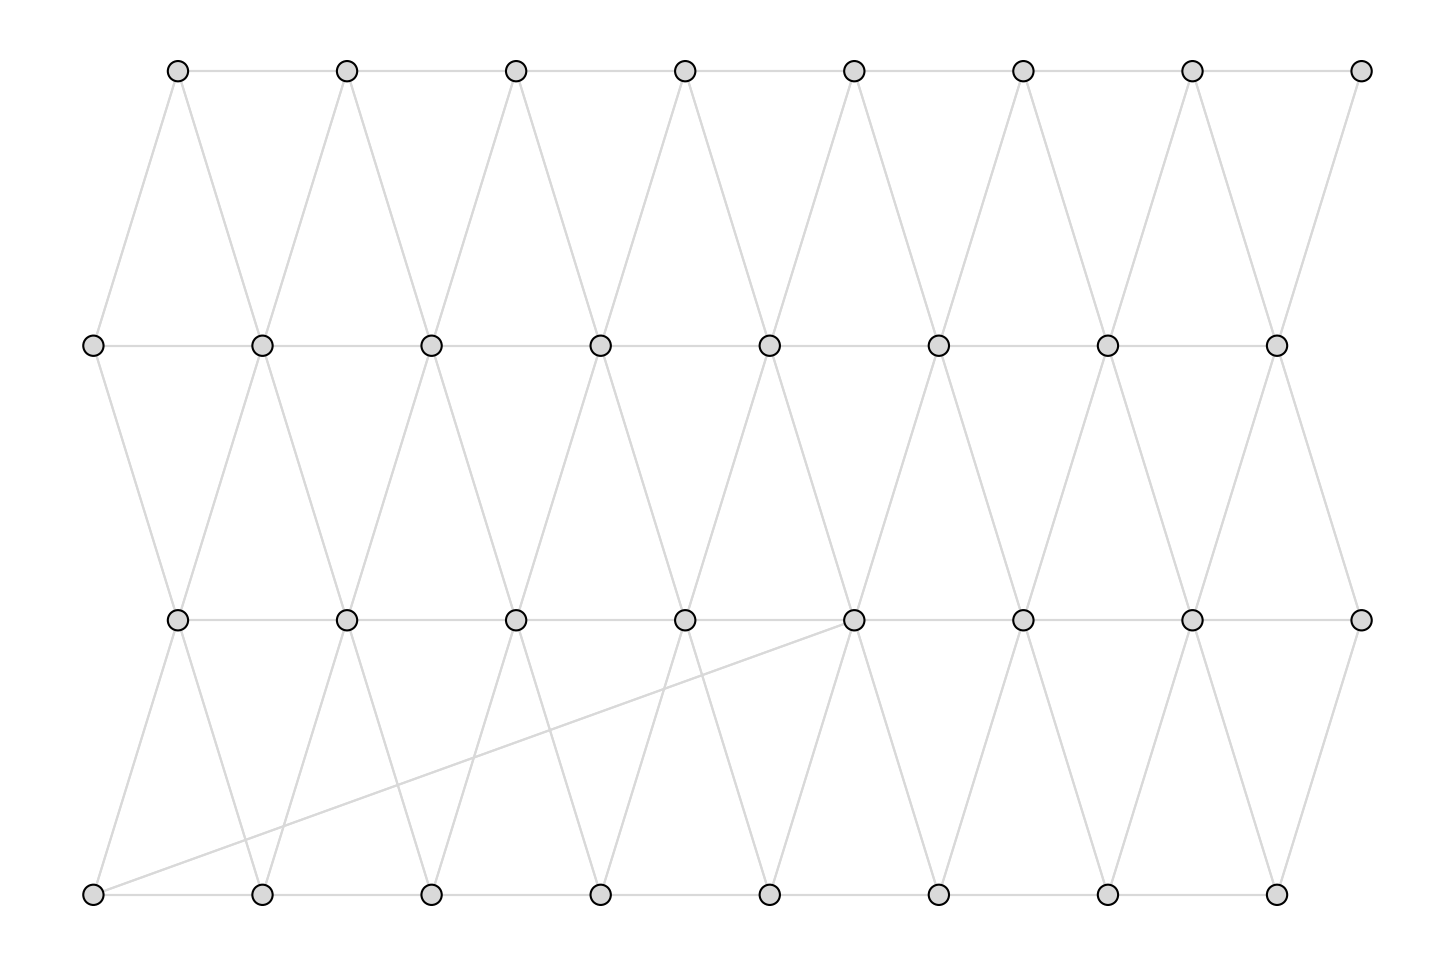

In [235]:
# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

## Default `feems` fit  

In [318]:
%%time
sp_Graph.fit_null_model()
#sp_Graph.fit(lamb = 1.0)

constant-w/variance fit, converged in 123 iterations, train_loss=3479.1321937
CPU times: user 956 ms, sys: 24.5 ms, total: 981 ms
Wall time: 291 ms


Surprisingly, it seems like the long range migration edge (0,12) is captured by the model! However, this could be because I set the long range migraton to be 4x more than corridor and 20x more than barrier migration rate. Below I use a root mean squared relative error to calculate deviation of estimated from simulated but weighted with respect to the estimated value
$$
\text{RMSRE} = \sqrt{1/n \sum_i \Big(\frac{X_i - T_i}{T_i}\Big)^2}
$$

In [5]:
def rmsre_edge_weights(graph, sp_Graph):
    # simulated graph edges
    sim_edges = np.array([graph[val[0]][val[1]]["w"] for _, val in enumerate(list(graph.edges))])
    return np.sqrt(np.mean(((sp_Graph.w-sim_edges)/sp_Graph.w)**2))

rmsre_edge_weights(graph, sp_Graph)/np.sqrt(np.mean(sp_Graph.w))

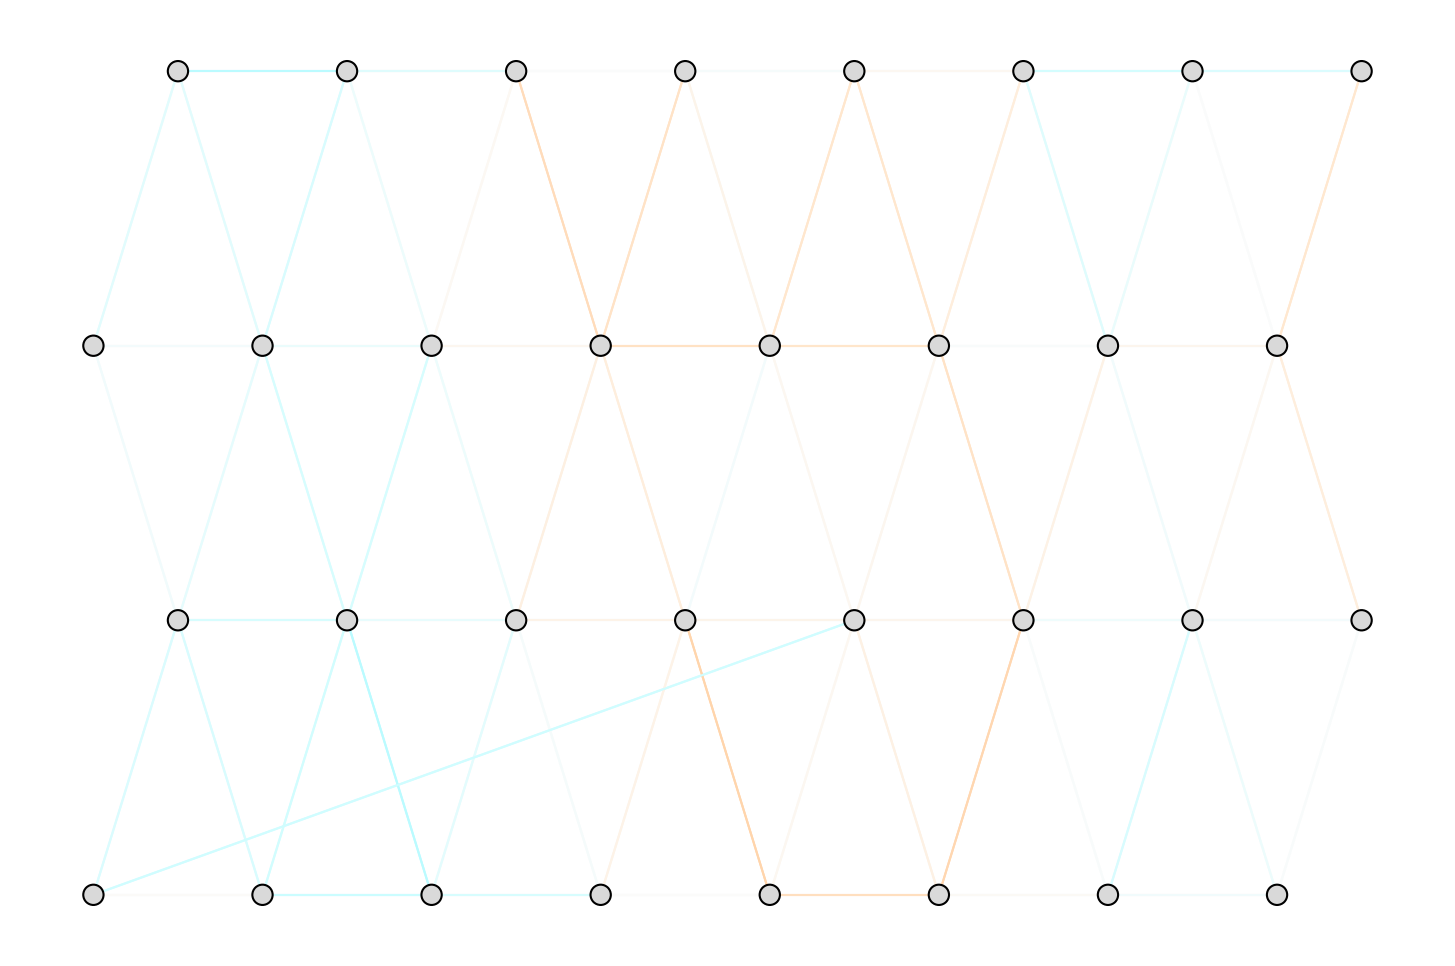

In [244]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

### Further testing with varying parameters 

Now, I will try out the following parameter regimes: more disconnected long range edges, weaker long range migration, and multiple incoming long range edges to same node. The previous parameter regime had one long range edge between node 0 and 12 with migration rate of 1.0 (compared to 0.5 in the corridors and 0.1 in the barrier). 

#### 1. Varying number of long range edges

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 150
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


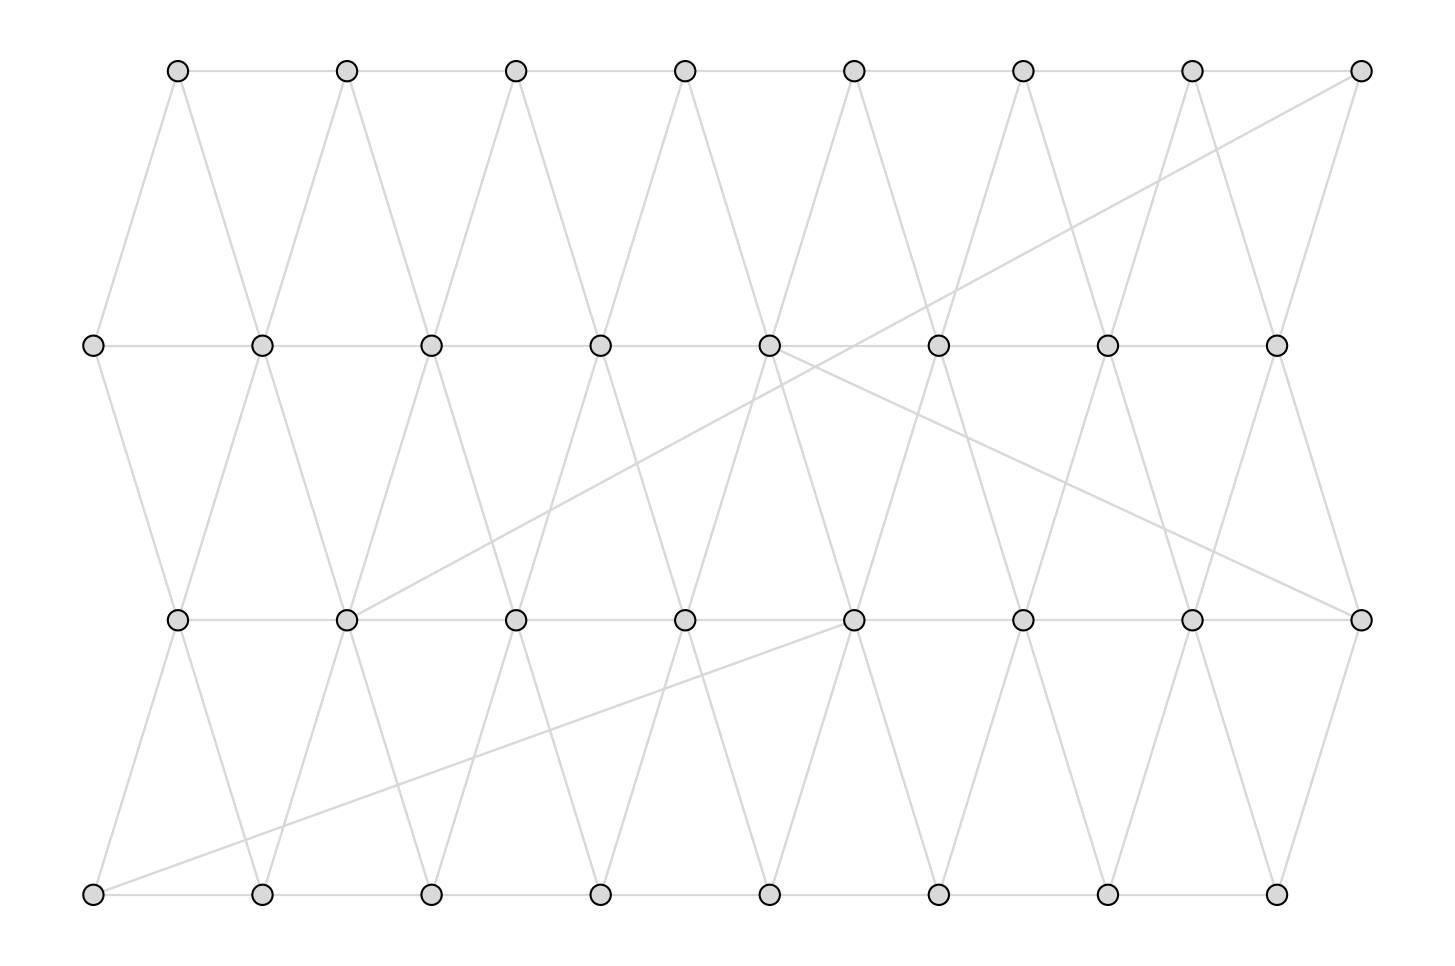

In [5]:
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=[(0,12),(15,20),(9,31)], long_range_edges=[1.0,1.0,1.0])
gen_test = simulate_genotypes(graph)
# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [6]:
%%time
sp_Graph.fit(lamb = 1.0)

constant-w/variance fit, converged in 128 iterations, train_loss=13100.7453796
lambda=1.0000000, alpha=1.3216153, converged in 15 iterations, train_loss=11717.7593576
CPU times: user 1.17 s, sys: 27.5 ms, total: 1.19 s
Wall time: 385 ms


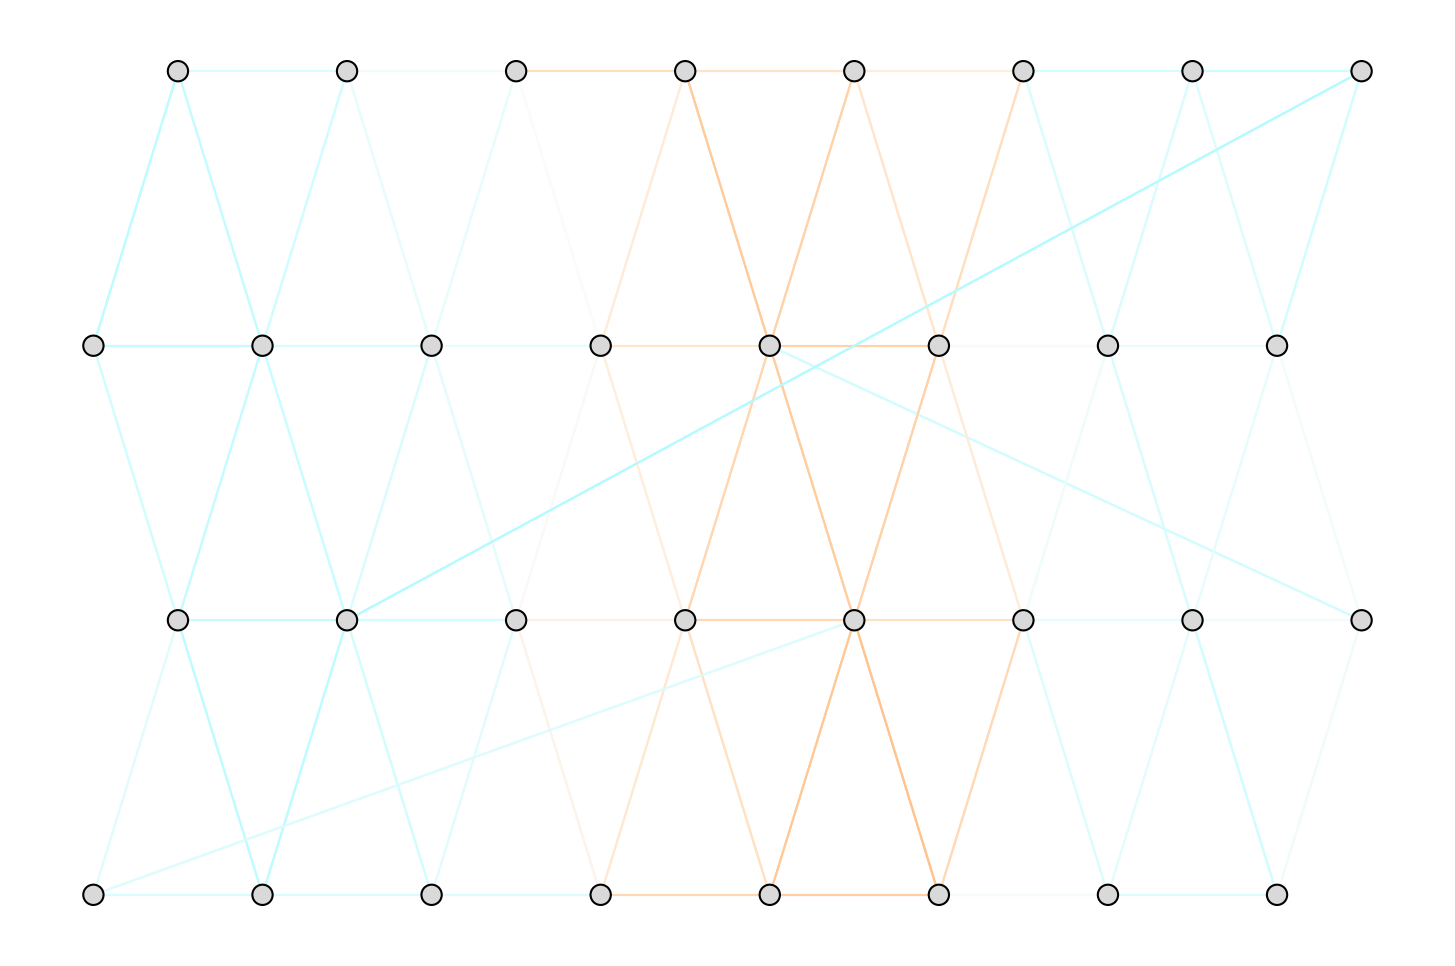

In [330]:
rmsre_edge_weights(graph, sp_Graph)/np.sqrt(np.mean(sp_Graph.w))
# plotting feems result
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

The above result shows that `feems` does pretty well in finding multiple long range migration edges, even with somewhat similar migration rates to the corridors (2x, compared to 4x from before). 

#### 2. Weak migration (similar to corridor rates)

Based on the results from the analysis below, I still find that `feems` does well in capturing these long range migrations. 

Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 500
Simulating ~SNP 600
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


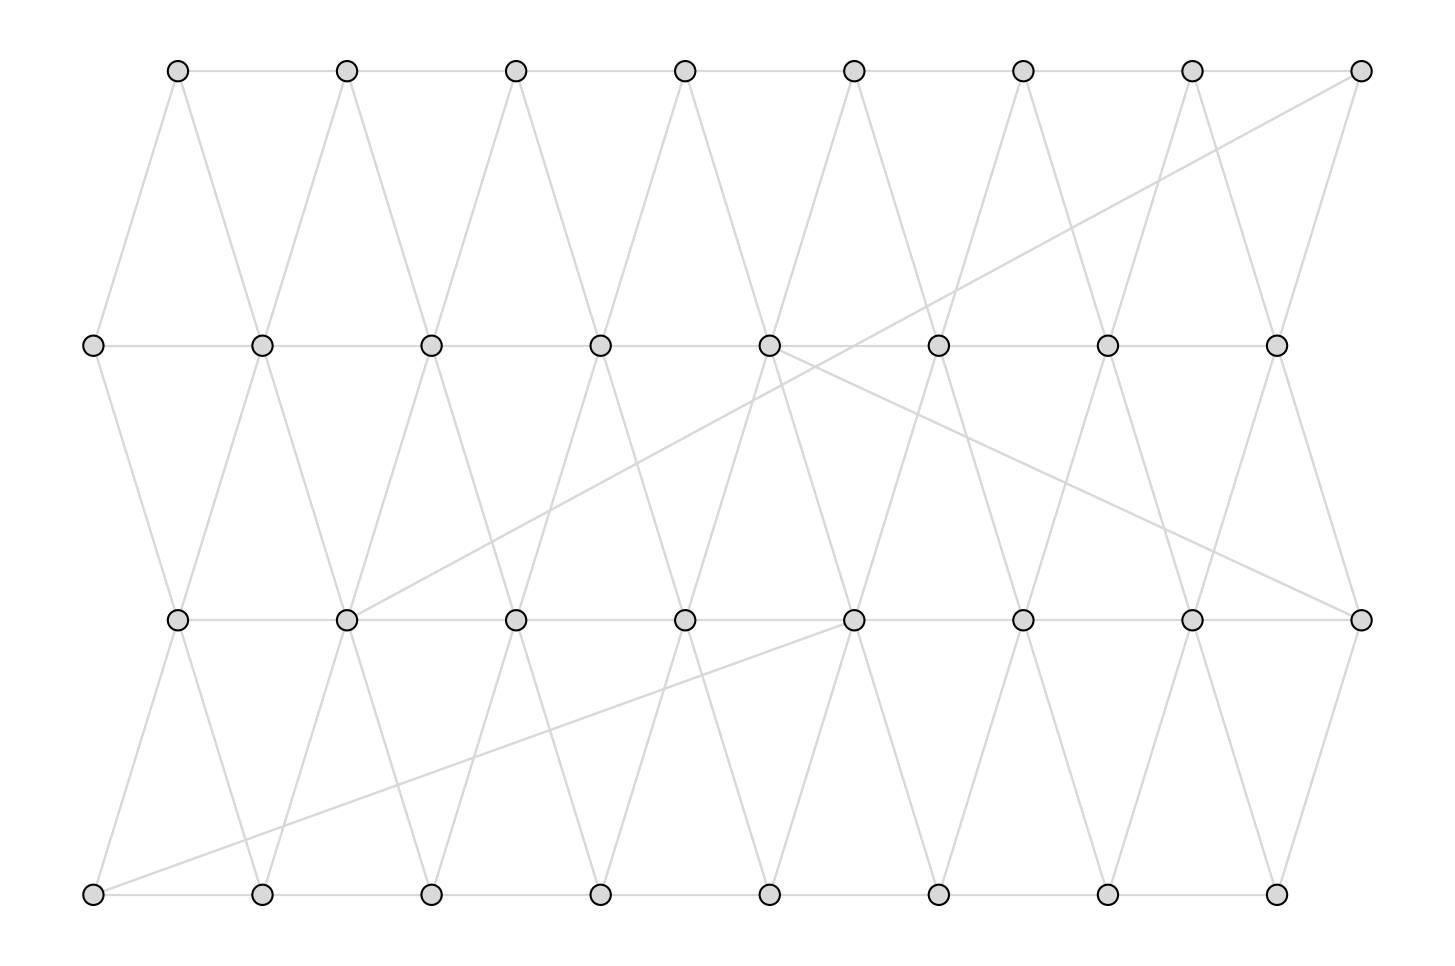

In [2]:
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=[(0,12),(15,20),(9,31)], long_range_edges=[0.5,0.5,0.5])
gen_test = simulate_genotypes(graph)
# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [3]:
%%time
sp_Graph.fit(lamb = 1.0)

constant-w/variance fit, converged in 138 iterations, train_loss=13297.0184798
lambda=1.0000000, alpha=1.3632157, converged in 12 iterations, train_loss=11833.8470775
CPU times: user 1.26 s, sys: 23.8 ms, total: 1.28 s
Wall time: 375 ms


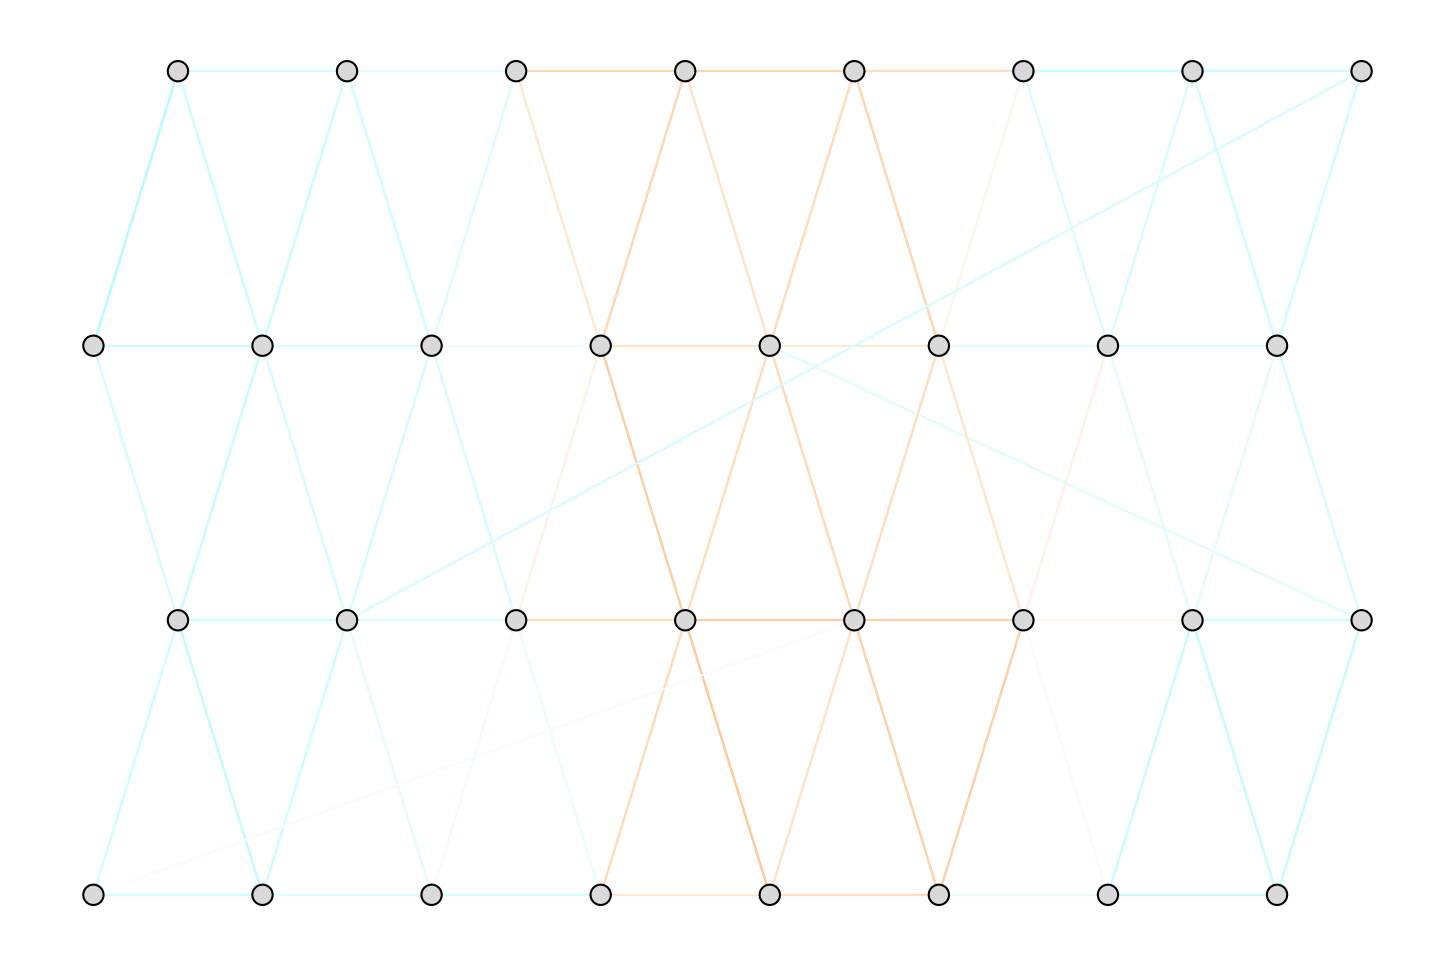

In [6]:
rmsre_edge_weights(graph, sp_Graph)/np.sqrt(np.mean(sp_Graph.w))
# plotting feems result
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

#### 3. Multiple long range migration edges to same node

Based on the results below, `feems` works well to estimate these long range migration edges accurately, even with multiple edges to the same node. 

Simulating ~SNP 0
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 500
Simulating ~SNP 600
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 900
Simulating ~SNP 950


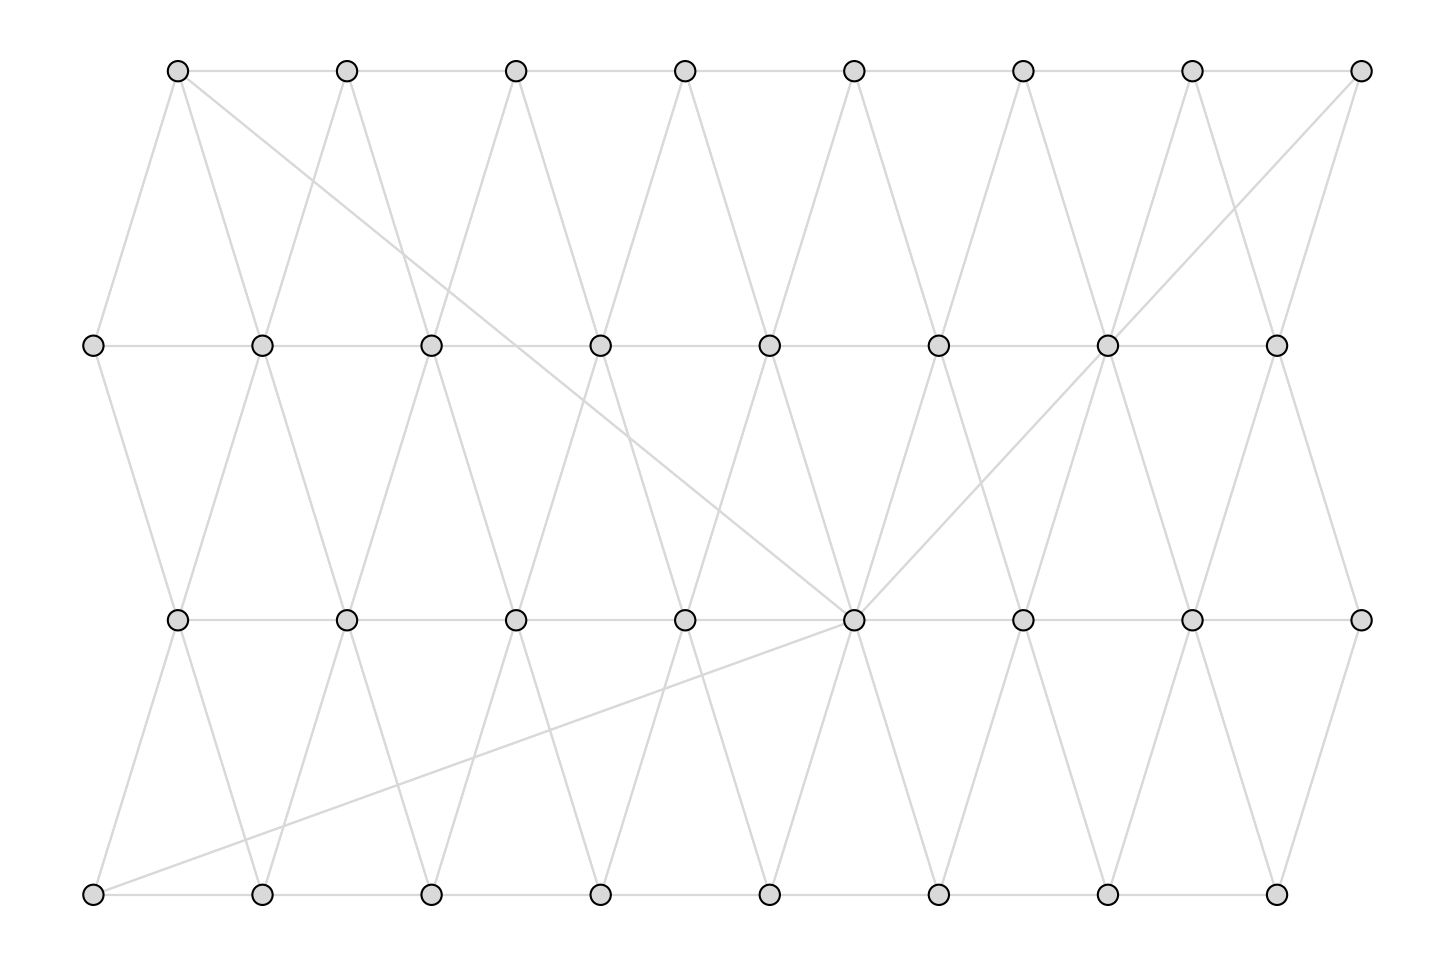

In [342]:
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=[(0,12),(12,31),(12,24)], long_range_edges=[1.0,1.0,1.0])
gen_test = simulate_genotypes(graph)
# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [345]:
%%time 
sp_Graph.fit(lamb = 0.1)

constant-w/variance fit, converged in 125 iterations, train_loss=14462.4293520
lambda=0.1000000, alpha=1.5938969, converged in 21 iterations, train_loss=12554.2589216
CPU times: user 1.16 s, sys: 28.9 ms, total: 1.19 s
Wall time: 352 ms


0.5849963513446104


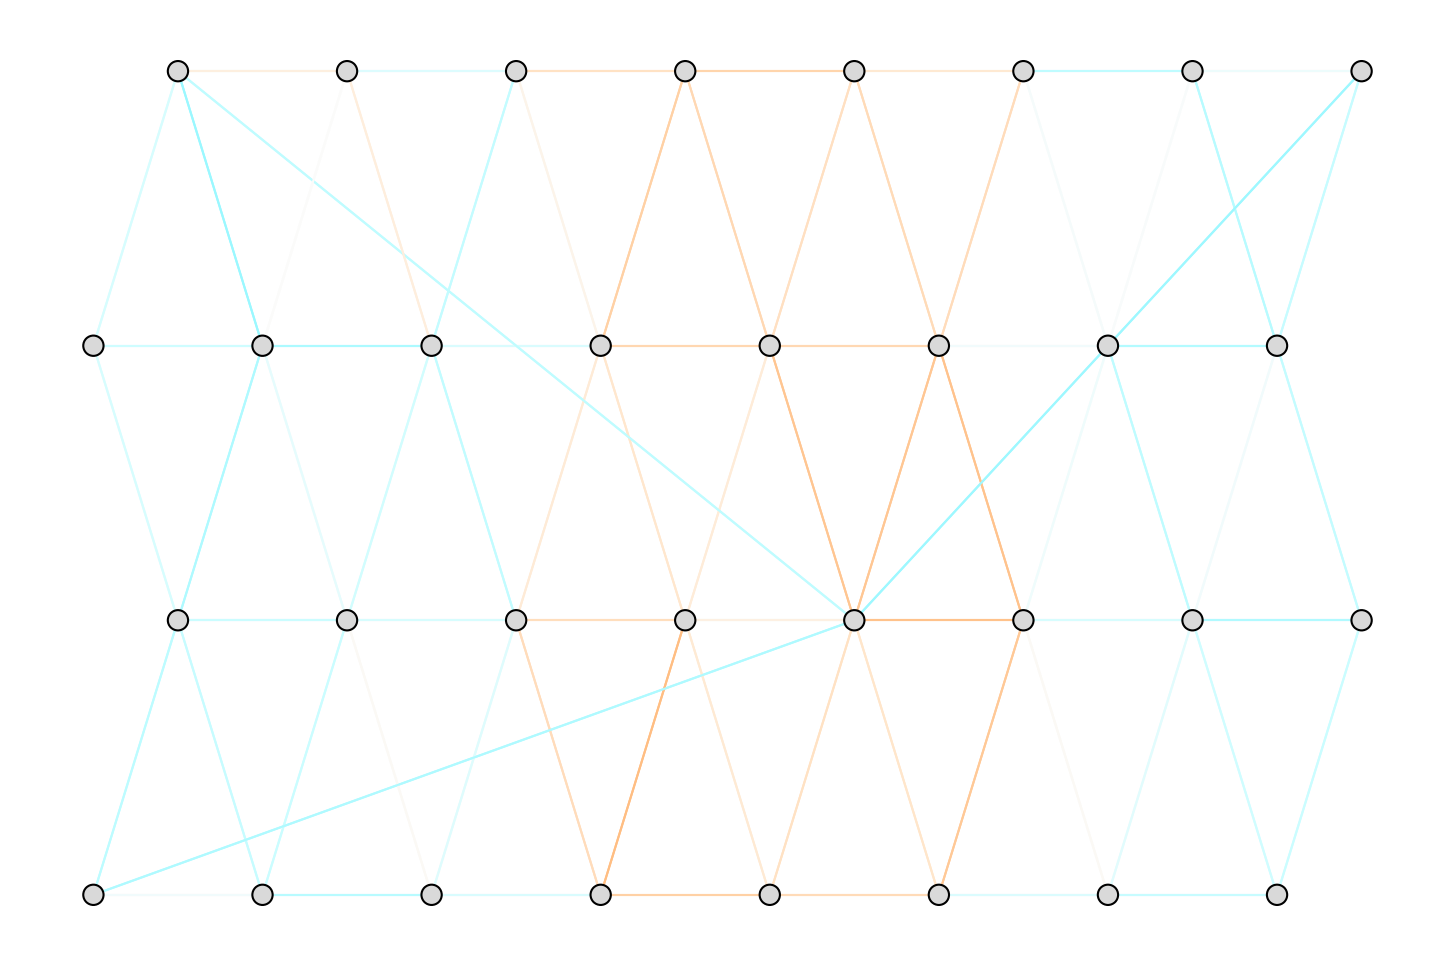

In [344]:
print(rmsre_edge_weights(graph, sp_Graph)/np.sqrt(np.mean(sp_Graph.w)))
# plotting feems result
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

### Spoofing the model by giving it all possible edges

Here, I will simulate under the model in **3** (multiple long range edges to same node) above, but will provide the model with edges connecting every population to every other population as a way of seeing if the model can detect the edges with long range migration. 

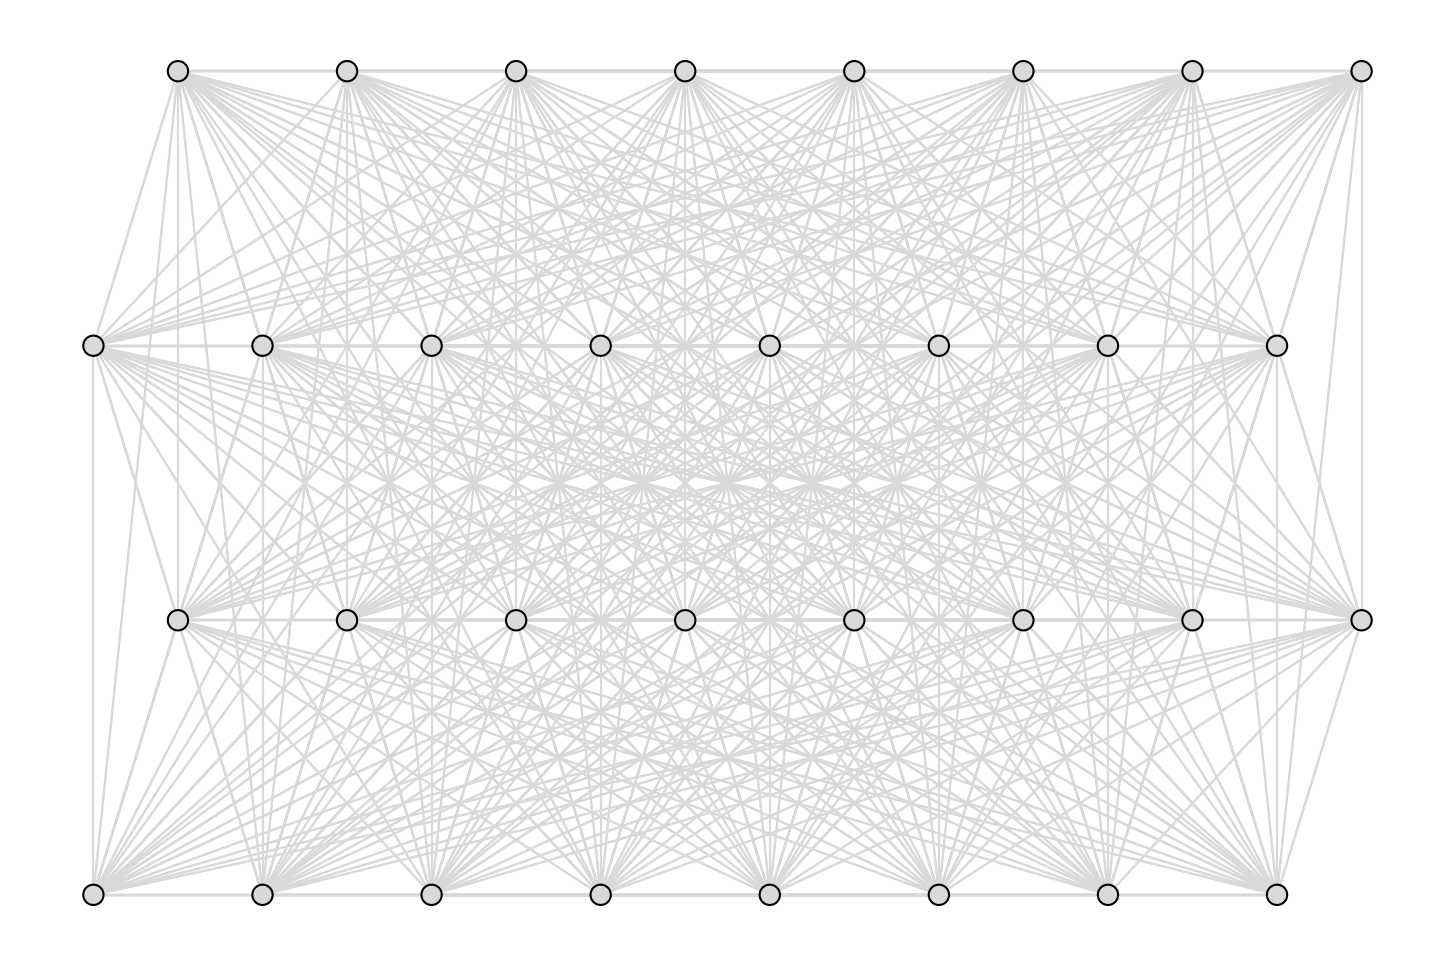

In [9]:
# constructing the graph object
## every combination of edge with same genotypes as before
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(list(it.combinations(np.arange(1,33),2))))

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [17]:
%%time
sp_Graph.fit(lamb = 0.1)

constant-w/variance fit, converged in 85 iterations, train_loss=16078.8566203
lambda=0.1000000, alpha=7.9050177, converged in 10 iterations, train_loss=15764.0032374
CPU times: user 876 ms, sys: 33.6 ms, total: 910 ms
Wall time: 323 ms


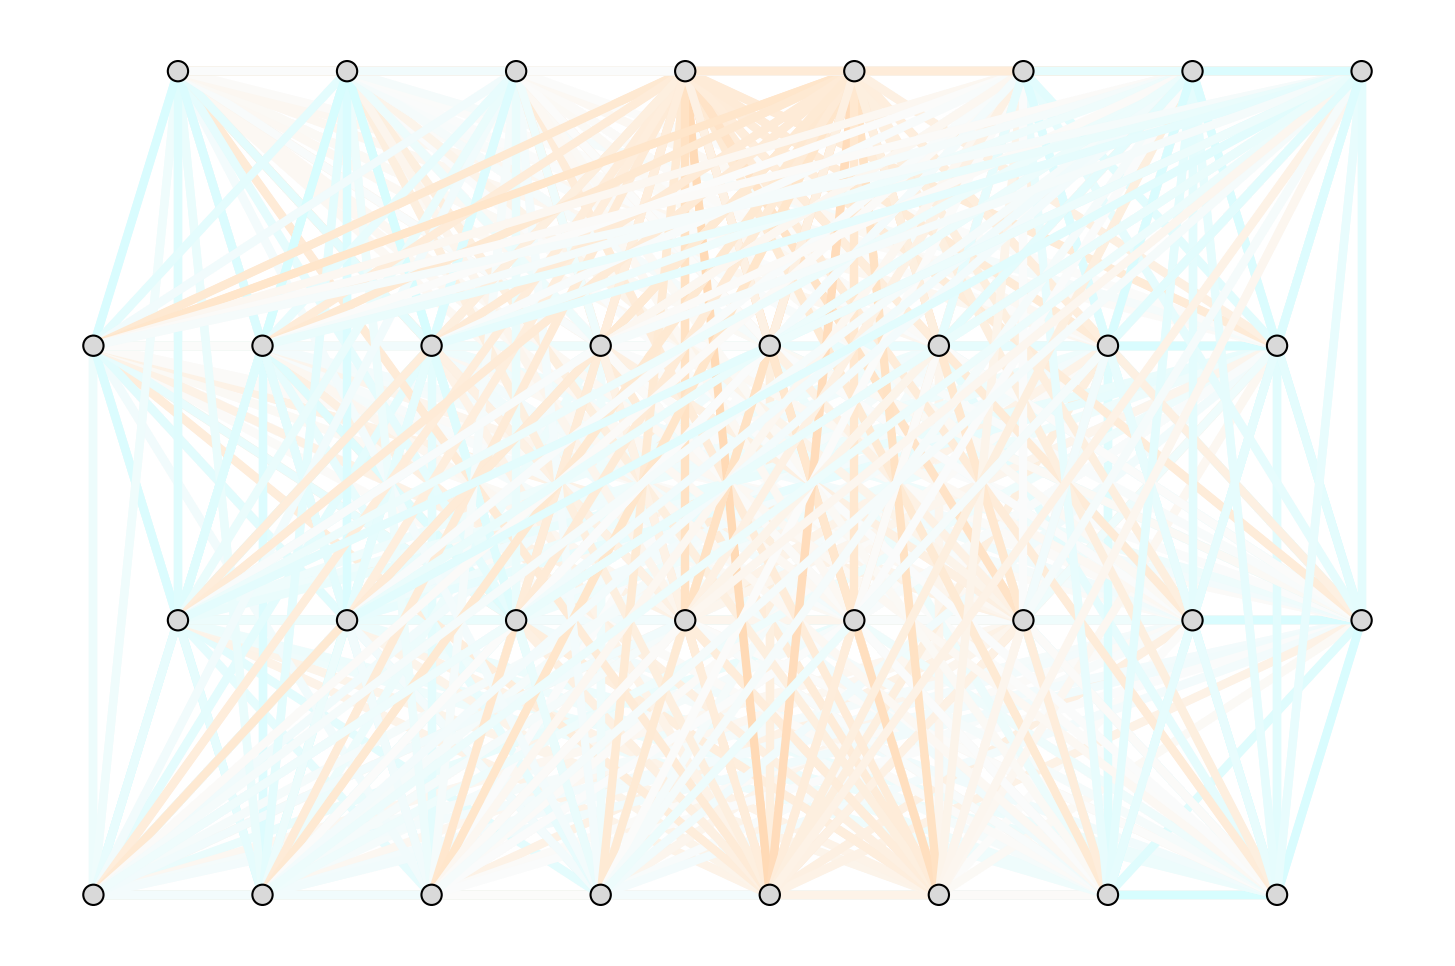

In [18]:
# plotting feems result
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

In [18]:
def cov_to_dist(S):
    s2 = np.diag(S).reshape(-1, 1)
    ones = np.ones((s2.shape[0], 1))
    D = s2 @ ones.T + ones @ s2.T - 2 * S
    return(D)

constant-w/variance fit, converged in 128 iterations, train_loss=13100.7453796
lambda=1.0000000, alpha=1.3216153, converged in 13 iterations, train_loss=11717.7593585


Text(0.5, 0, 'fitted distance')

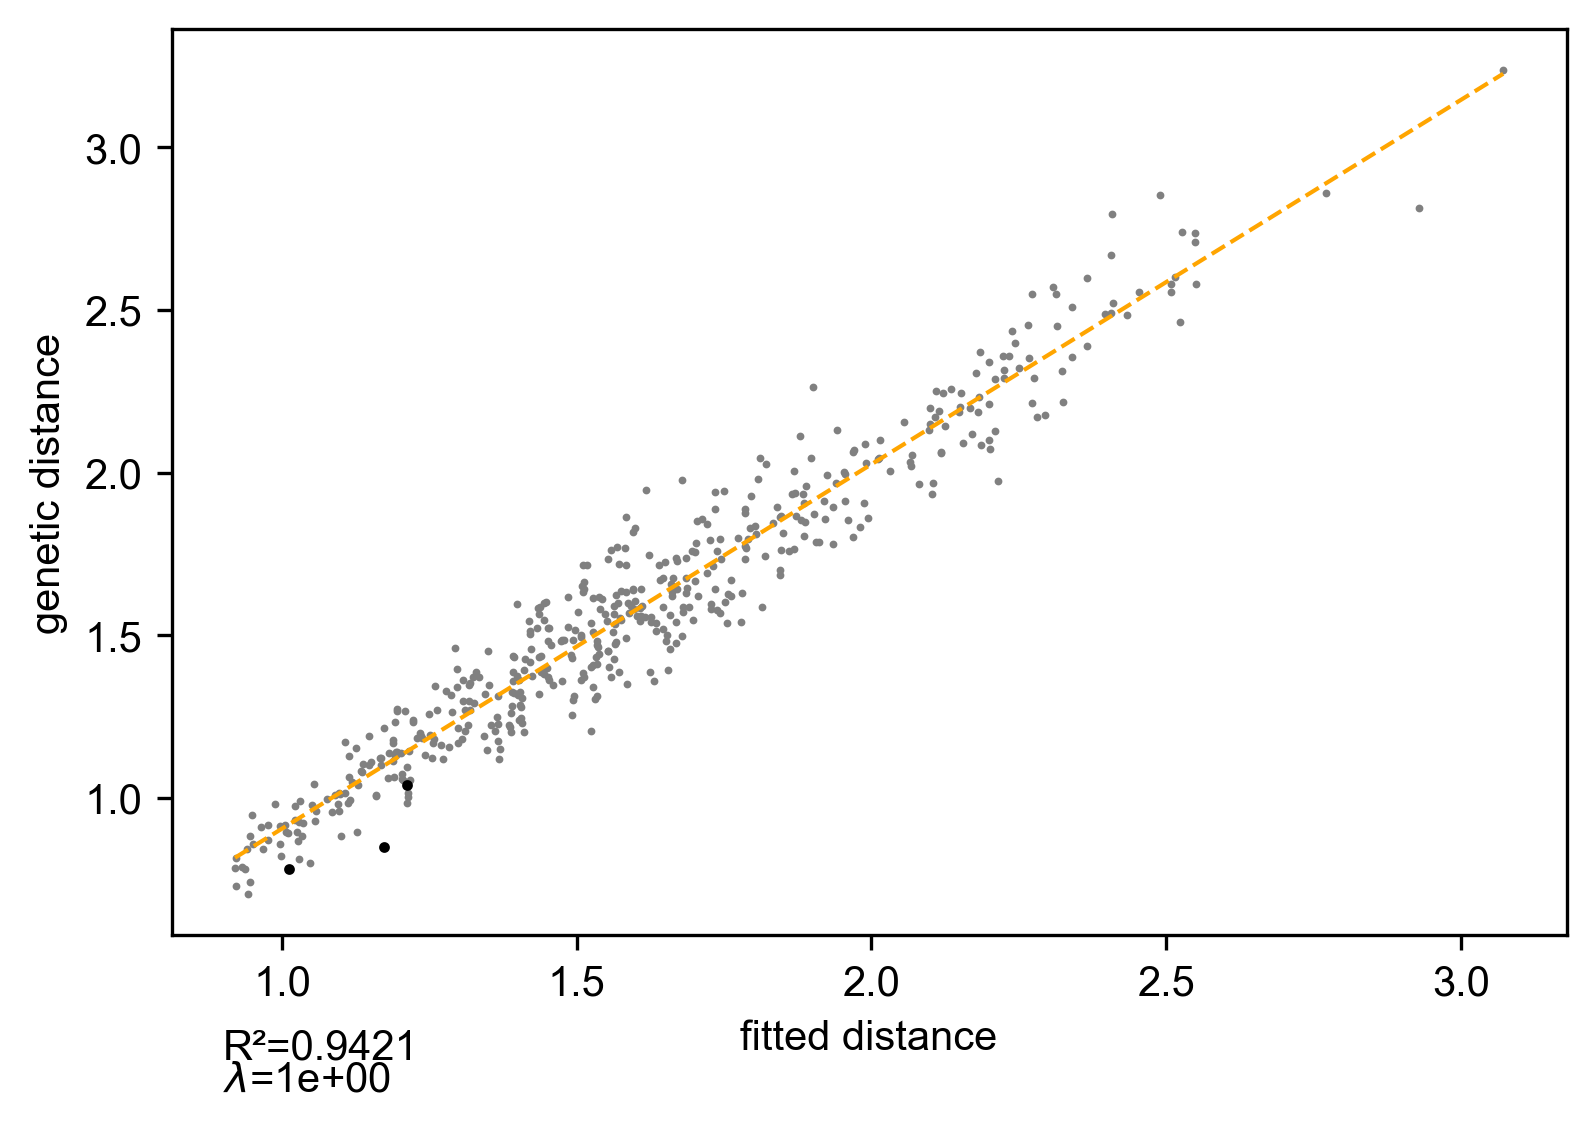

In [33]:
fig = plt.figure(dpi=300)
## prototyping plot for observed vs simulated...
tril_idx = np.tril_indices(sp_Graph.n_observed_nodes, k=-1)
ax = fig.add_subplot()
lamb = 1.00
sp_Graph.fit(lamb=lamb,
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_Graph.comp_graph_laplacian(sp_Graph.w)

obj = Objective(sp_Graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]

# computing the vector index for lower triangular matrix of long range nodes
lrn_idx = [np.int(val[0] + 0.5*val[1]*(val[1]+1) - val[1]) if val[0]<val[1] else np.int(val[1] + 0.5*val[0]*(val[0]+1) - val[0]) for val in lrn]

X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax.scatter(fit_dist, emp_dist, 
           marker=".", alpha=1, zorder=0, color="grey", s=3)
ax.scatter(fit_dist[lrn_idx], emp_dist[lrn_idx], 
           marker=".", alpha=1, zorder=0, color="black", s=10)
x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax.text(0.9, 0.1, "$\lambda$={:1.0e}".format(lamb))
ax.text(0.9, 0.2, "R²={:.4f}".format(res.rsquared))
ax.set_ylabel("genetic distance")
ax.set_xlabel("fitted distance")

In [17]:
lrn[0][::-1]
[np.int(val[0] + 0.5*val[1]*(val[1]+1) - val[1]) if val[0]<val[1] else np.int(val[1] + 0.5*val[0]*(val[0]+1) - val[0]) for val in lrn]

[66, 205, 474]

Text(0.5, 0, 'estimated edge weights')

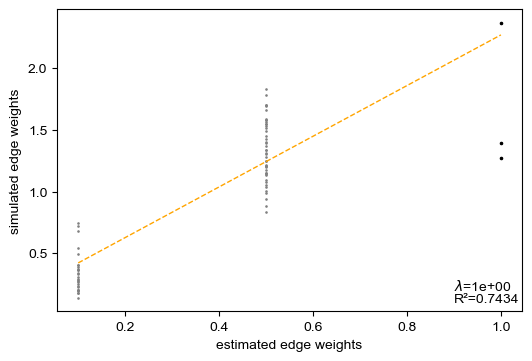

In [34]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
## prototyping plot of estimated vs true edge weights...
sim_edges = np.array([graph[val[0]][val[1]]["w"] for _, val in enumerate(list(graph.edges))])
X = sm.add_constant(sim_edges)
mod = sm.OLS(sp_Graph.w, X)
res = mod.fit()
muhat, betahat = res.params
lr_idx = [list(graph.edges).index(val) for val in lrn]
ax.scatter(sim_edges, sp_Graph.w, 
           marker=".", alpha=1, zorder=0, color="grey", s=3)
ax.scatter(sim_edges[lr_idx], sp_Graph.w[lr_idx], 
           marker=".", alpha=1, zorder=0, color="black", s=10)
x_ = np.linspace(np.min(sim_edges), np.max(sim_edges), 20)
ax.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax.text(0.9, 0.1, "R²={:.4f}".format(res.rsquared))
ax.text(0.9, 0.2, "$\lambda$={:1.0e}".format(lamb))
ax.set_ylabel("simulated edge weights")
ax.set_xlabel("estimated edge weights")

## Investigating the 'greedy' approach to fitting long range edges

First, I will see if the covariance of allele frequencies across nodes tells us something about which nodes could potentially have a long range migration. This seems promising, in that for node 0 is found to covary with node 12 the third-most (right after its neighboring nodes). 

In [222]:
np.set_printoptions(threshold=np.inf)
np.argsort(sp_Graph.S[16,:],)
#sp_Graph.S[12,:]-np.max(sp_Graph.S[12,:])

array([30, 31,  5, 21,  6, 15, 23,  7, 29, 22, 13, 14, 28, 27,  4, 12, 20,
       11,  0,  3,  2,  9, 19, 26, 10, 24, 18,  1, 17,  8, 25, 16])